## HW4: Probabilistic Clustering and Gaussian Mixture Models

In this lab, we compare k-means and Gaussian Mixture Models (GMM)
on two overlapping Iris species (versicolor and virginica).

We focus on two informative features:
- Petal length
- Petal width

In [18]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# from sklearn.datasets import load_iris
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans
# from sklearn.mixture import GaussianMixture
# from sklearn.metrics import adjusted_rand_score

# sns.set(style='whitegrid')



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, confusion_matrix



In [20]:
# Load and Prepare Data


iris = load_iris(as_frame=True)
df = iris.frame

# Keep only versicolor (1) and virginica (2)
df = df[df["target"].isin([1, 2])]

# Select two features
X = df[["petal length (cm)", "petal width (cm)"]].values
y_true = df["target"].values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [22]:
# Task 1
# ---- KMeans ----
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# ---- GMM (Spherical) ----
gmm_spherical = GaussianMixture(
    n_components=2,
    covariance_type='spherical',
    random_state=42
)
gmm_spherical_labels = gmm_spherical.fit_predict(X_scaled)

# ---- GMM (Full Covariance) ----
gmm_full = GaussianMixture(
    n_components=2,
    covariance_type='full',
    random_state=42
)
gmm_full_labels = gmm_full.fit_predict(X_scaled)


#
print("KMeans Centroids:\n", kmeans.cluster_centers_)
print("\nSpherical GMM Means:\n", gmm_spherical.means_)
print("\nFull GMM Means:\n", gmm_full.means_)



KMeans Centroids:
 [[-0.69425104 -0.75444267]
 [ 0.88359224  0.96019977]]

Spherical GMM Means:
 [[-0.77771545 -0.82259795]
 [ 0.79612439  0.84206927]]

Full GMM Means:
 [[-0.70741427 -0.75000819]
 [ 0.84247611  0.8932022 ]]


In [23]:
# Evaluate Agreement
print("\nAdjusted Rand Index (higher is better)")
print("KMeans:", adjusted_rand_score(y_true, kmeans_labels))
print("Spherical GMM:", adjusted_rand_score(y_true, gmm_spherical_labels))
print("Full GMM:", adjusted_rand_score(y_true, gmm_full_labels))



Adjusted Rand Index (higher is better)
KMeans: 0.7721314419105764
Spherical GMM: 0.7720979591836735
Full GMM: 0.8448351863643042


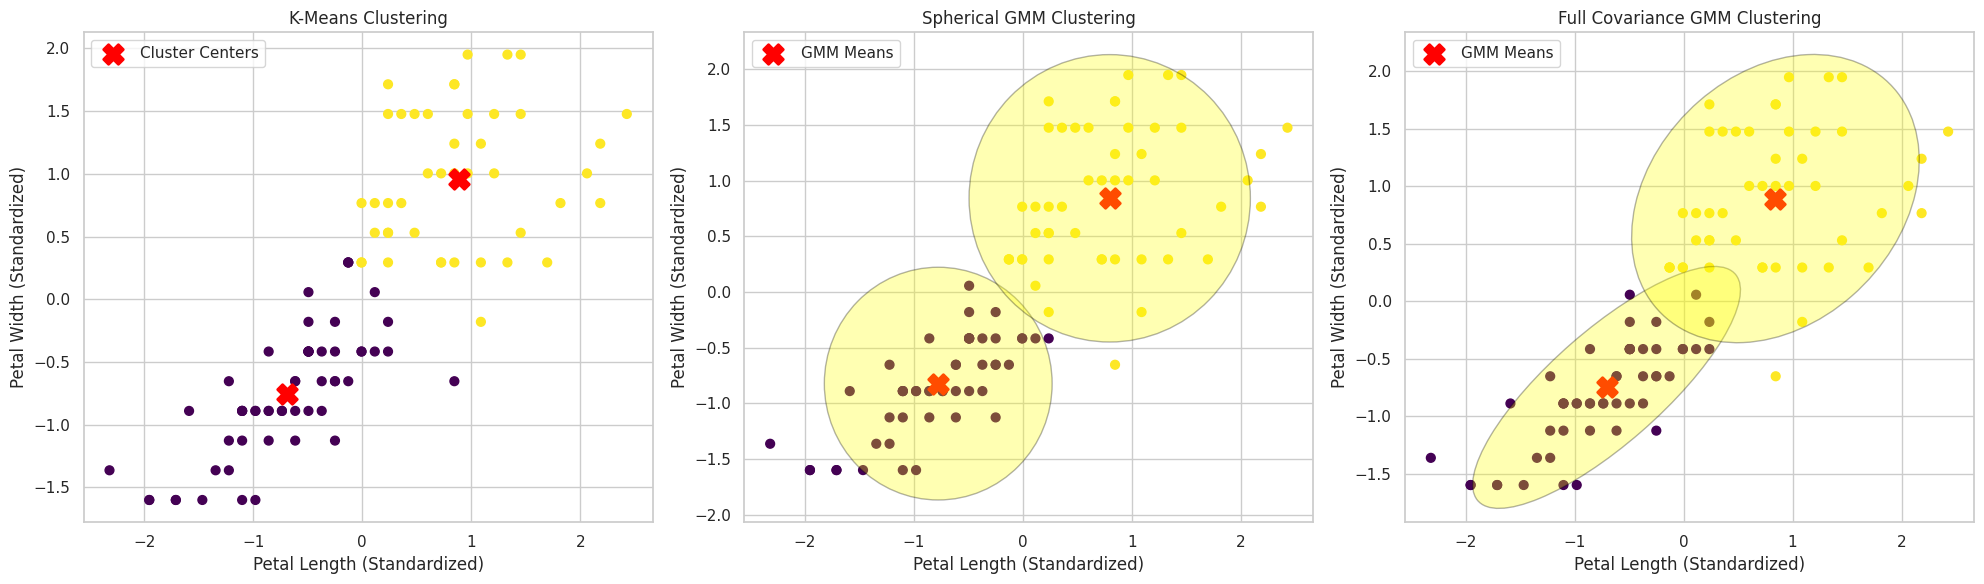

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Subplot 1: K-Means
ax[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans_labels, cmap='viridis', s=40)
ax[0].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
              marker='X', s=200, linewidths=2, color='red', label='Cluster Centers')
ax[0].set_title('K-Means Clustering')
ax[0].set_xlabel('Petal Length (Standardized)')
ax[0].set_ylabel('Petal Width (Standardized)')
ax[0].legend()

# Subplot 2: Spherical GMM
ax[1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=gmm_sph_labels, cmap='viridis', s=40)
ax[1].scatter(gmm_spherical.means_[:, 0], gmm_spherical.means_[:, 1],
              marker='X', s=200, linewidths=2, color='red', label='GMM Means')
for k in range(gmm_spherical.n_components):
    draw_ellipse(gmm_spherical.means_[k], gmm_spherical.covariances_[k] * np.eye(2), ax[1],
                 n_std=2, facecolor='yellow', alpha=0.3, edgecolor='black')
ax[1].set_title('Spherical GMM Clustering')
ax[1].set_xlabel('Petal Length (Standardized)')
ax[1].set_ylabel('Petal Width (Standardized)')
ax[1].legend()

# Subplot 3: Full Covariance GMM
ax[2].scatter(X_scaled[:, 0], X_scaled[:, 1], c=gmm_full_labels, cmap='viridis', s=40)
ax[2].scatter(gmm_full.means_[:, 0], gmm_full.means_[:, 1],
              marker='X', s=200, linewidths=2, color='red', label='GMM Means')
for k in range(gmm_full.n_components):
    draw_ellipse(gmm_full.means_[k], gmm_full.covariances_[k], ax[2],
                 n_std=2, facecolor='yellow', alpha=0.3, edgecolor='black')
ax[2].set_title('Full Covariance GMM Clustering')
ax[2].set_xlabel('Petal Length (Standardized)')
ax[2].set_ylabel('Petal Width (Standardized)')
ax[2].legend()

plt.tight_layout()
plt.show()


Number of uncertain points: 3

Assignments comparison for uncertain points:
Index 73 | KMeans: 1 | GMM: 1 | Max Posterior: 0.579
Index 77 | KMeans: 1 | GMM: 1 | Max Posterior: 0.579
Index 99 | KMeans: 1 | GMM: 1 | Max Posterior: 0.591


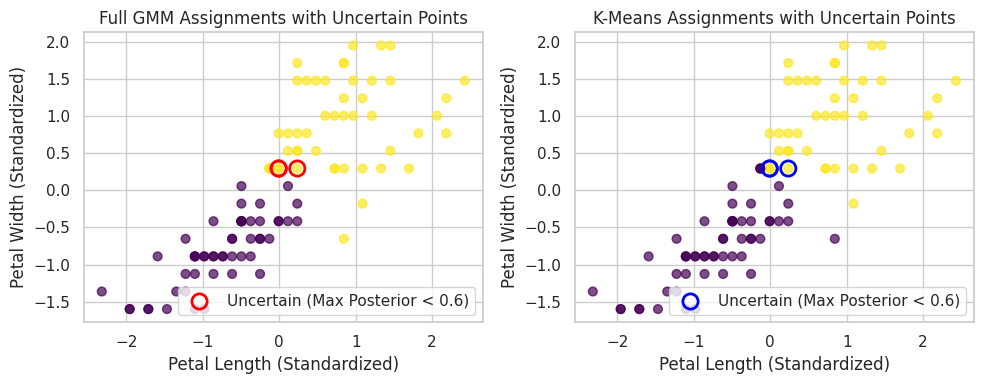

In [35]:
# Task 2: Soft vs Hard Assignment
# Posterior probabilities from full GMM
posterior_probs = gmm_full.predict_proba(X_scaled)

# Maximum posterior per point
max_posterior = posterior_probs.max(axis=1)

# Identify uncertain points
threshold = 0.6
uncertain_idx = np.where(max_posterior < threshold)[0]

print("\nNumber of uncertain points:", len(uncertain_idx))

# Compare assignments
print("\nAssignments comparison for uncertain points:")
for idx in uncertain_idx:
    print(f"Index {idx} | KMeans: {kmeans_labels[idx]} "
          f"| GMM: {gmm_full_labels[idx]} "
          f"| Max Posterior: {max_posterior[idx]:.3f}")

# --- Visualization Graphs for Uncertainty and Assignment Comparison ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Subplot 1: Full GMM Assignments with Uncertain Points Highlighted
ax1.scatter(X_scaled[:, 0], X_scaled[:, 1],
            c=gmm_full_labels, cmap="viridis", s=40, alpha=0.7)
ax1.scatter(X_scaled[uncertain_idx, 0],
            X_scaled[uncertain_idx, 1],
            facecolors='none',
            edgecolors='red',
            linewidths=2,
            s=120,
            label=f"Uncertain (Max Posterior < {threshold})")
ax1.set_xlabel("Petal Length (Standardized)")
ax1.set_ylabel("Petal Width (Standardized)")
ax1.set_title("Full GMM Assignments with Uncertain Points")
ax1.legend()

# Subplot 2: K-Means Assignments with Uncertain Points Highlighted
ax2.scatter(X_scaled[:, 0], X_scaled[:, 1],
            c=kmeans_labels, cmap="viridis", s=40, alpha=0.7)
ax2.scatter(X_scaled[uncertain_idx, 0],
            X_scaled[uncertain_idx, 1],
            facecolors='none',
            edgecolors='blue',
            linewidths=2,
            s=120,
            label=f"Uncertain (Max Posterior < {threshold})")
ax2.set_xlabel("Petal Length (Standardized)")
ax2.set_ylabel("Petal Width (Standardized)")
ax2.set_title("K-Means Assignments with Uncertain Points")
ax2.legend()

plt.tight_layout()
plt.show()

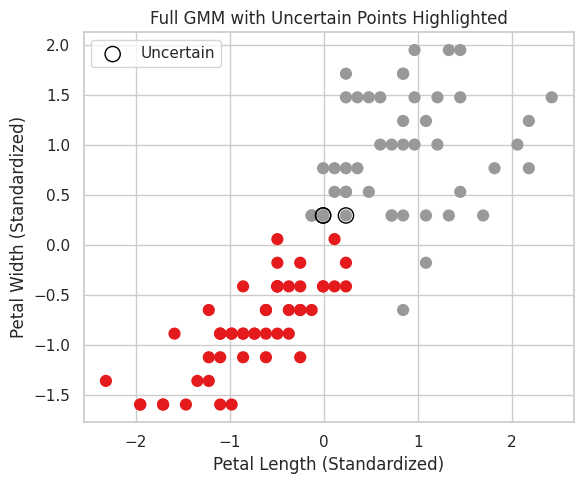

In [26]:
# Visualization of Uncertainty
plt.figure(figsize=(6,5))
plt.scatter(X_scaled[:,0], X_scaled[:,1],
            c=gmm_full_labels, cmap="Set1", s=60)

plt.scatter(X_scaled[uncertain_idx,0],
            X_scaled[uncertain_idx,1],
            facecolors='none',
            edgecolors='black',
            s=120,
            label="Uncertain")

plt.xlabel("Petal Length (Standardized)")
plt.ylabel("Petal Width (Standardized)")
plt.title("Full GMM with Uncertain Points Highlighted")
plt.legend()
plt.tight_layout()
plt.savefig("a4_task2_fig1_AD.png")
plt.show()

## Load Data and Restrict to Two Classes

In [2]:
iris = load_iris()
X = iris.data
y = iris.target

# Keep only versicolor (1) and virginica (2)
mask = y != 0
X = X[mask]
y = y[mask] - 1  # relabel to 0 and 1

print('Class distribution:', np.bincount(y))

Class distribution: [50 50]


## Select Two Features

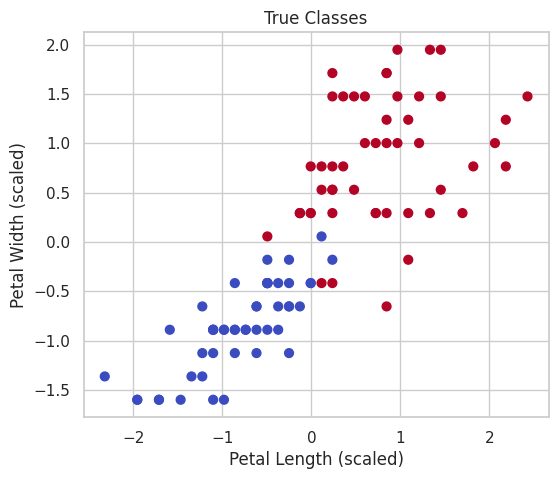

In [3]:
X = X[:, [2, 3]]  # petal length, petal width

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

plt.figure(figsize=(6,5))
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y, cmap='coolwarm', s=40)
plt.xlabel('Petal Length (scaled)')
plt.ylabel('Petal Width (scaled)')
plt.title('True Classes')
plt.show()

# Task 1: k-Means vs Spherical GMM vs full GMM

1. Fit k-means with K=2.
2. Fit a spherical GMM with K=2.
3. Fit a full covariance GMM with K = 2

In [15]:
# k-means
kmeans = KMeans(n_clusters=2, random_state=42)
km_labels = kmeans.fit_predict(X_scaled)

# spherical GMM
gmm_spherical = GaussianMixture(n_components=2, covariance_type='spherical', random_state=42)
gmm_sph_labels = gmm_spherical.fit_predict(X_scaled)

# Full GMM
gmm_full = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm_full.fit(X_scaled) # Fit the GMM
gmm_full_labels = gmm_full.predict(X_scaled) # Get the labels




print('ARI (k-means vs true):', adjusted_rand_score(y, km_labels))
print('ARI (spherical GMM vs true):', adjusted_rand_score(y, gmm_sph_labels))
print('ARI (full GMM vs true):', adjusted_rand_score(y, gmm_full_labels)) # Use gmm_full_labels

ARI (k-means vs true): 0.7721314419105764
ARI (spherical GMM vs true): 0.7720979591836735
ARI (full GMM vs true): 0.8448351863643042


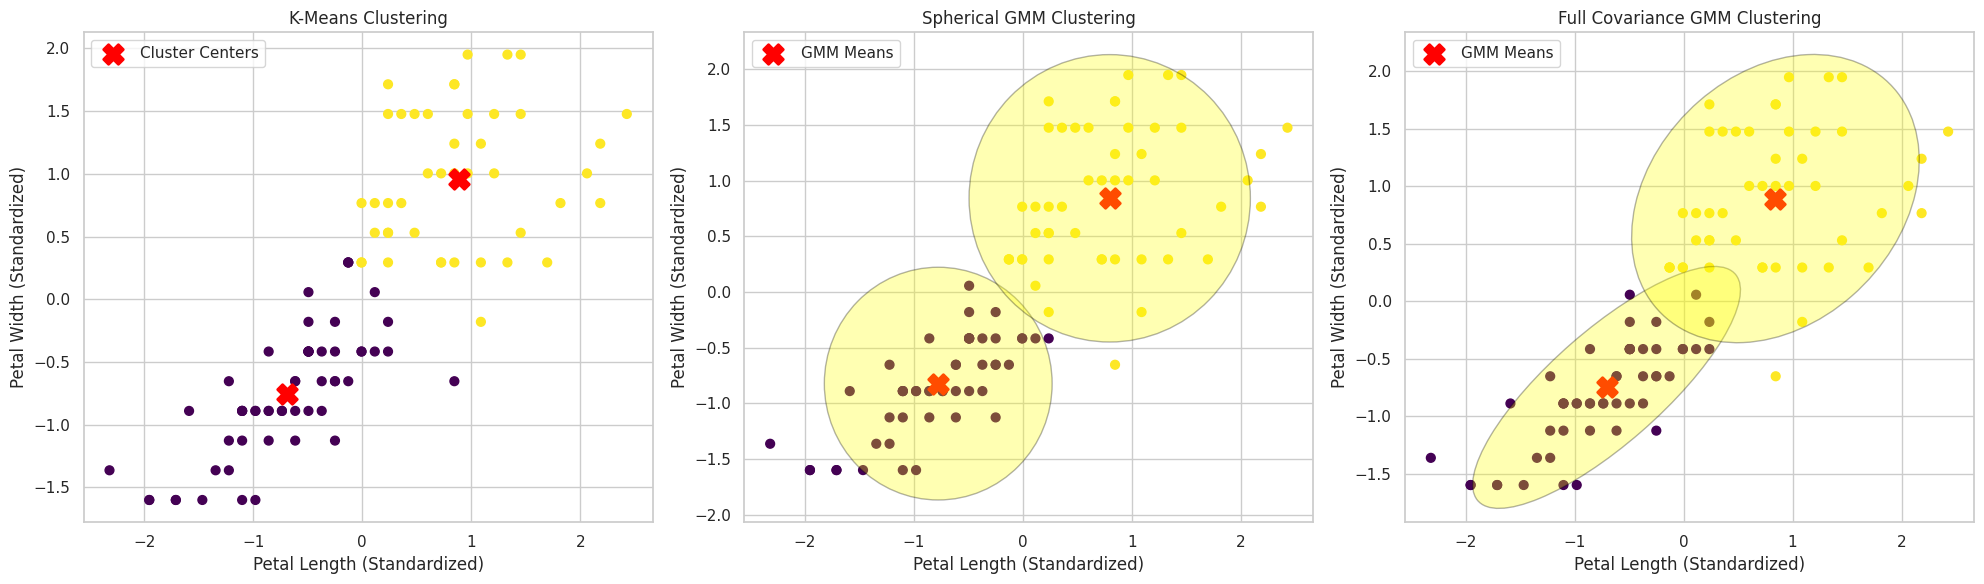

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Subplot 1: K-Means
ax[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans_labels, cmap='viridis', s=40)
ax[0].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
              marker='X', s=200, linewidths=2, color='red', label='Cluster Centers')
ax[0].set_title('K-Means Clustering')
ax[0].set_xlabel('Petal Length (Standardized)')
ax[0].set_ylabel('Petal Width (Standardized)')
ax[0].legend()

# Subplot 2: Spherical GMM
ax[1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=gmm_sph_labels, cmap='viridis', s=40)
ax[1].scatter(gmm_spherical.means_[:, 0], gmm_spherical.means_[:, 1],
              marker='X', s=200, linewidths=2, color='red', label='GMM Means')
for k in range(gmm_spherical.n_components):
    draw_ellipse(gmm_spherical.means_[k], gmm_spherical.covariances_[k] * np.eye(2), ax[1],
                 n_std=2, facecolor='yellow', alpha=0.3, edgecolor='black')
ax[1].set_title('Spherical GMM Clustering')
ax[1].set_xlabel('Petal Length (Standardized)')
ax[1].set_ylabel('Petal Width (Standardized)')
ax[1].legend()

# Subplot 3: Full Covariance GMM
ax[2].scatter(X_scaled[:, 0], X_scaled[:, 1], c=gmm_full_labels, cmap='viridis', s=40)
ax[2].scatter(gmm_full.means_[:, 0], gmm_full.means_[:, 1],
              marker='X', s=200, linewidths=2, color='red', label='GMM Means')
for k in range(gmm_full.n_components):
    draw_ellipse(gmm_full.means_[k], gmm_full.covariances_[k], ax[2],
                 n_std=2, facecolor='yellow', alpha=0.3, edgecolor='black')
ax[2].set_title('Full Covariance GMM Clustering')
ax[2].set_xlabel('Petal Length (Standardized)')
ax[2].set_ylabel('Petal Width (Standardized)')
ax[2].legend()

plt.tight_layout()
plt.show()

Number of uncertain points: 3


/tmp/ipython-input-1515656786.py:21: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_scaled[uncertain, 0], X_scaled[uncertain, 1], c='red', marker='x', s=100, label=f'Uncertain Points (max prob < {uncertain_threshold})', edgecolor='k')


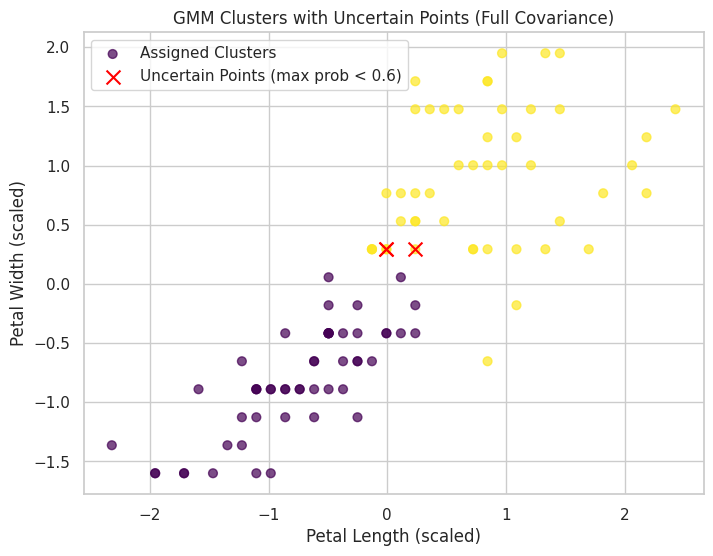

In [17]:
posteriors = gmm_full.predict_proba(X_scaled)
#add your code here
print('Number of uncertain points:', uncertain.sum())
#make a nice plot that display overlappong points in different color or plotting character

In [36]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax, n_std=2, facecolor='none', alpha=0.5, edgecolor='black'):
    """
    Draws an ellipse representing the covariance of a Gaussian distribution.

    Parameters
    ----------
    position : array_like
        The mean of the distribution.
    covariance : array_like
        The covariance matrix of the distribution.
    ax : matplotlib.axes.Axes
        The axes on which to draw the ellipse.
    n_std : int
        The number of standard deviations to determine the ellipse size.
    facecolor : str
        The face color of the ellipse.
    alpha : float
        The transparency of the ellipse.
    edgecolor : str
        The edge color of the ellipse.
    """
    # Ensure covariance is a 2x2 matrix
    if covariance.ndim == 0:  # scalar, for spherical covariance_type
        covariance = np.array([[covariance.item(), 0], [0, covariance.item()]])
    elif covariance.ndim == 1: # 1D array, for diagonal covariance_type
        covariance = np.diag(covariance)
    elif covariance.shape == (2,): # If it's already a 1D array of length 2, treat as diagonal
        covariance = np.diag(covariance)
    # If it's already a 2x2 matrix, no conversion needed

    # Calculate eigenvalues and eigenvectors
    vals, vecs = np.linalg.eigh(covariance)

    # Calculate angle of rotation from the largest eigenvector
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))

    # Calculate base width and height for 1 standard deviation
    width, height = 2 * np.sqrt(vals)

    # Create and add ellipse to the axes using the specified n_std
    ell = Ellipse(xy=position, width=n_std * width, height=n_std * height, angle=angle,
                  facecolor=facecolor, alpha=alpha, edgecolor=edgecolor)
    ax.add_patch(ell)

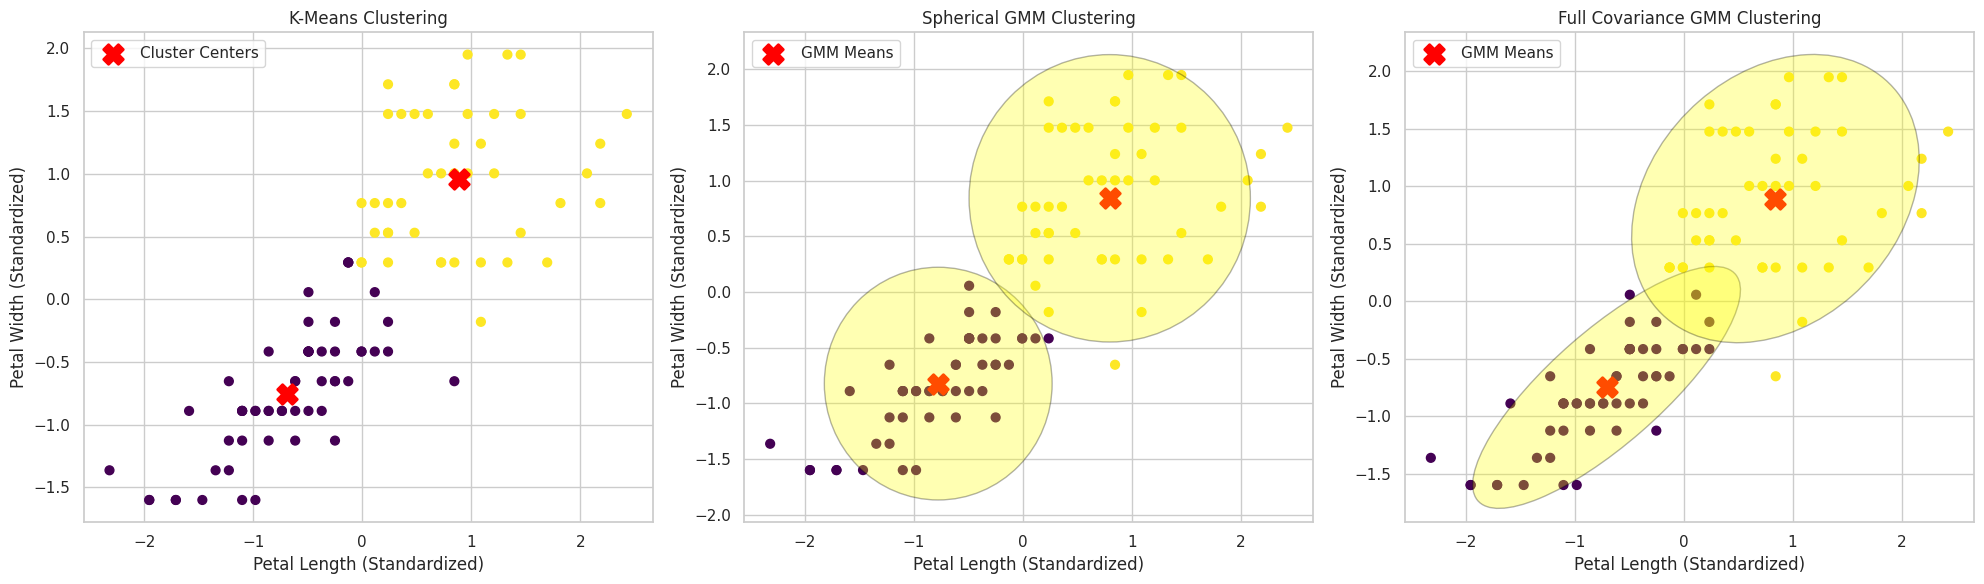

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Subplot 1: K-Means
ax[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans_labels, cmap='viridis', s=40)
ax[0].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
              marker='X', s=200, linewidths=2, color='red', label='Cluster Centers')
ax[0].set_title('K-Means Clustering')
ax[0].set_xlabel('Petal Length (Standardized)')
ax[0].set_ylabel('Petal Width (Standardized)')
ax[0].legend()

# Subplot 2: Spherical GMM
ax[1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=gmm_sph_labels, cmap='viridis', s=40)
ax[1].scatter(gmm_spherical.means_[:, 0], gmm_spherical.means_[:, 1],
              marker='X', s=200, linewidths=2, color='red', label='GMM Means')
for k in range(gmm_spherical.n_components):
    draw_ellipse(gmm_spherical.means_[k], gmm_spherical.covariances_[k] * np.eye(2), ax[1],
                 n_std=2, facecolor='yellow', alpha=0.3, edgecolor='black')
ax[1].set_title('Spherical GMM Clustering')
ax[1].set_xlabel('Petal Length (Standardized)')
ax[1].set_ylabel('Petal Width (Standardized)')
ax[1].legend()

# Subplot 3: Full Covariance GMM
ax[2].scatter(X_scaled[:, 0], X_scaled[:, 1], c=gmm_full_labels, cmap='viridis', s=40)
ax[2].scatter(gmm_full.means_[:, 0], gmm_full.means_[:, 1],
              marker='X', s=200, linewidths=2, color='red', label='GMM Means')
for k in range(gmm_full.n_components):
    draw_ellipse(gmm_full.means_[k], gmm_full.covariances_[k], ax[2],
                 n_std=2, facecolor='yellow', alpha=0.3, edgecolor='black')
ax[2].set_title('Full Covariance GMM Clustering')
ax[2].set_xlabel('Petal Length (Standardized)')
ax[2].set_ylabel('Petal Width (Standardized)')
ax[2].legend()

plt.tight_layout()
plt.show()

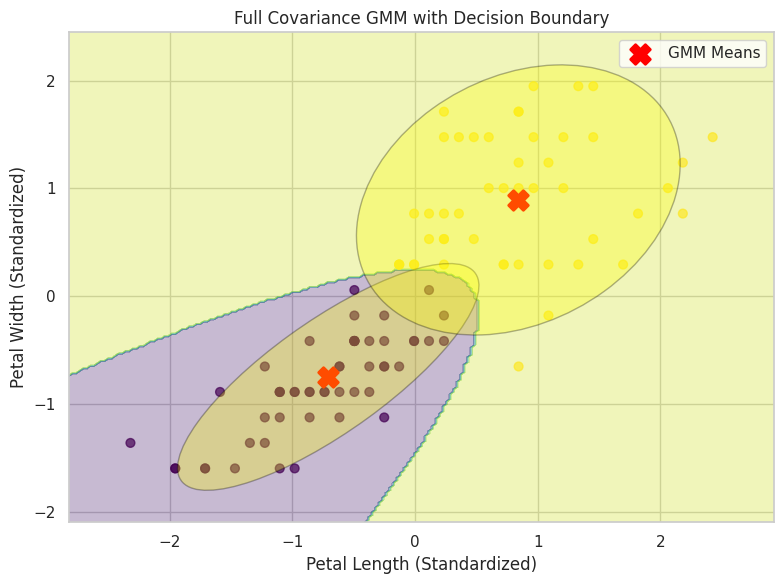

In [40]:
def plot_GMM_decision_boundary(gmm, X, ax):
    """
    Plots the decision boundary for a GMM along with data points, means, and covariance ellipses.
    """
    # Create a meshgrid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                             np.linspace(y_min, y_max, 200))

    # Predict cluster labels for each point in the meshgrid
    Z = gmm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')

    # Plot the original data points
    ax.scatter(X[:, 0], X[:, 1], c=gmm.predict(X), s=40, cmap='viridis', alpha=0.7)

    # Plot GMM means and covariance ellipses
    ax.scatter(gmm.means_[:, 0], gmm.means_[:, 1],
              marker='X', s=200, linewidths=2, color='red', label='GMM Means')
    for k in range(gmm.n_components):
        draw_ellipse(gmm.means_[k], gmm.covariances_[k], ax,
                     n_std=2, facecolor='yellow', alpha=0.3, edgecolor='black')

    ax.set_title('Full Covariance GMM with Decision Boundary')
    ax.set_xlabel('Petal Length (Standardized)')
    ax.set_ylabel('Petal Width (Standardized)')
    ax.legend()

# Create a new figure and axes to plot the decision boundary
fig, ax = plt.subplots(figsize=(8, 6))
plot_GMM_decision_boundary(gmm_full, X_scaled, ax)
plt.tight_layout()
plt.show()

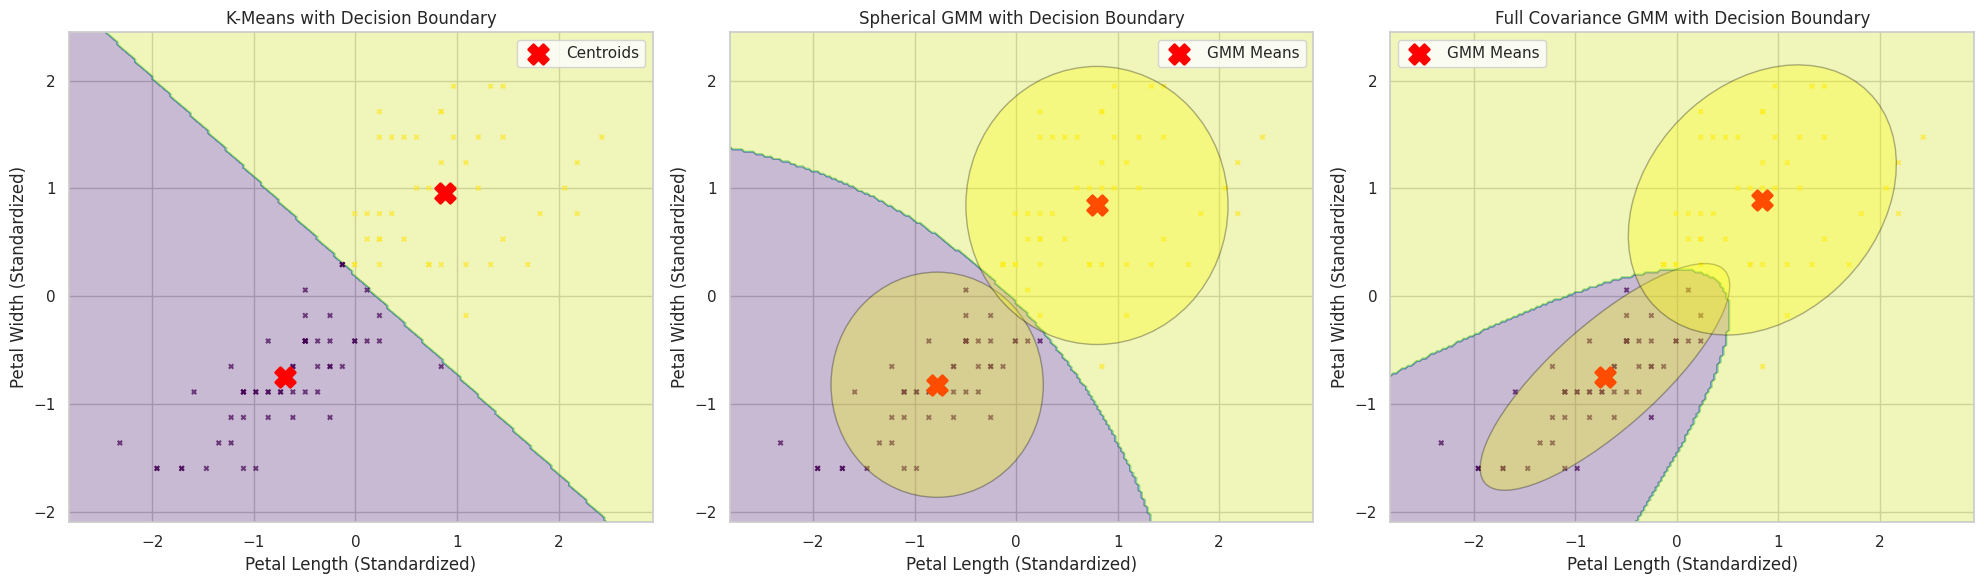

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

def plot_decision_boundary(model, X, ax, title, is_gmm=True):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                             np.linspace(y_min, y_max, 200))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    # Re-added data points with subtle non-circular markers
    ax.scatter(X[:, 0], X[:, 1], c=model.predict(X), s=10, marker='x', cmap='viridis', alpha=0.7)

    if is_gmm:
        ax.scatter(model.means_[:, 0], model.means_[:, 1],
                   marker='X', s=200, linewidths=2, color='red', label='GMM Means')
        for k in range(model.n_components):
            # Ensure the correct covariance is passed based on type
            if model.covariance_type == 'spherical':
                # For spherical, gmm.covariances_ is a 1D array of variances
                draw_ellipse(model.means_[k], model.covariances_[k] * np.eye(2), ax, n_std=2, facecolor='yellow', alpha=0.3, edgecolor='black')
            else: # full, tied, diag
                draw_ellipse(model.means_[k], model.covariances_[k], ax, n_std=2, facecolor='yellow', alpha=0.3, edgecolor='black')
    else: # KMeans
        ax.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1],
                   marker='X', s=200, linewidths=2, color='red', label='Centroids')

    ax.set_title(title)
    ax.set_xlabel('Petal Length (Standardized)')
    ax.set_ylabel('Petal Width (Standardized)')
    ax.legend()

# Plot for K-Means
plot_decision_boundary(kmeans, X_scaled, axes[0], 'K-Means with Decision Boundary', is_gmm=False)

# Plot for Spherical GMM
plot_decision_boundary(gmm_spherical, X_scaled, axes[1], 'Spherical GMM with Decision Boundary')

# Plot for Full Covariance GMM
plot_decision_boundary(gmm_full, X_scaled, axes[2], 'Full Covariance GMM with Decision Boundary')

plt.tight_layout()
plt.show()